<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Informe1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cobalto 60
lims: 2400 - 3700 (están juntas)

<>:149: SyntaxWarning: invalid escape sequence '\D'
<>:149: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1451816074.py:149: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Cuentas/$\Delta t$")


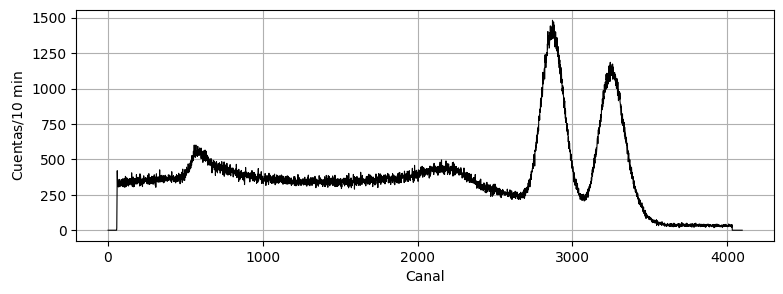


Resultados del ajuste (dos gaussianas + fondo lineal):

Pico 1 (menor μ):
  μ1 = 2.87e+03 ± 0.196 canales
  σ1 = 71.4 ± 0.215 canales
  FWHM1 = 168 ± 0.505 canales
  A1 = 1.21e+03 ± 2.99 cuentas (altura pico)
  I1 (área) = 2.17e+05 ± 668 canal·cuentas

Pico 2:
  μ2 = 3.26e+03 ± 0.25 canales
  σ2 = 79.5 ± 0.28 canales
  FWHM2 = 187 ± 0.66 canales
  A2 = 1e+03 ± 2.86 cuentas
  I2 (área) = 2e+05 ± 745 canal·cuentas

Fondo: m = -0.204 ± 0.00216 cuentas/canal, b = 782 ± 6.62 cuentas


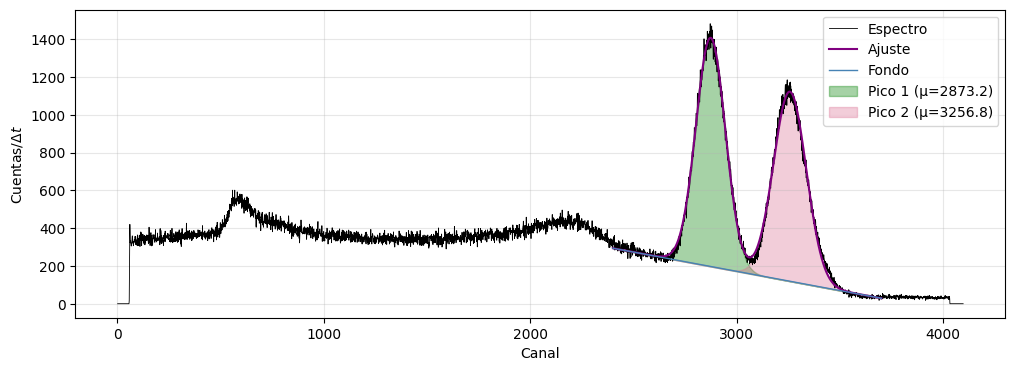


Tabla de resultados:

        Parámetro         Pico 1         Pico 2
      A (cuentas)           1210           1003
        μ (canal)  2873 ± 0.1957    3257 ± 0.25
        σ (canal) 71.39 ± 0.2146 79.46 ± 0.2804
     FWHM (canal) 168.1 ± 0.5054 187.1 ± 0.6603
I (canal·cuentas)      2.166e+05      1.998e+05
               ΔI          667.8          744.9


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


def gaussian(x, A, mu, sigma):                                                        # una gaussiana
    return A * np.exp(-(mu - x)**2 / (2 * sigma**2))

def two_gauss_linbg(x, A1, mu1, sigma1, A2, mu2, sigma2, m, b):                       # dos gaussianas + fondo
    return (gaussian(x, A1, mu1, sigma1) + gaussian(x, A2, mu2, sigma2) + m*x + b)


archivo = "Co60_10minNaI.csv"                                                         # cambio entre .csv
data = pd.read_csv(archivo)                                                           # columna 0: canal, columna 1: cuentas

x = data.iloc[:,0].values
y = data.iloc[:,1].values


# para ver el espectro completo
plt.figure(figsize=(9,3))
plt.plot(x, y, lw=0.8, color='black')
plt.xlabel("Canal")
plt.ylabel("Cuentas/$10$ min")                                                         # acomodar el \Delta t de acuerdo al núcleo
#plt.title("Espectro completo")
plt.grid(True)
plt.show()


# selecciono la region que contiene dos picos
x_min = 2400                                                                          # rango seleccionado a "ojo" después de ver el espectro. No acercarse demasiado al sitio donde empiezan a subir las cuentas para no dañar el ajuste
x_max = 3700
mask = (x >= x_min) & (x <= x_max)
x_region = x[mask]
y_region = y[mask]


# para detectar los máximos locales
peaks, _ = find_peaks(y_region, height=np.max(y_region)*0.2, distance=50)
if len(peaks) >= 2:                                                                   # si hay al menos dos máximos locales
    peaks_sorted = peaks[np.argsort(y_region[peaks])][::-1][:2]                       # tomo los más altos
    mu1_guess = x_region[peaks_sorted[0]]                                             # estimo las mu
    mu2_guess = x_region[peaks_sorted[1]]
else:
    idx_sorted = np.argsort(y_region)[::-1]                                           # si no hay locales, estimo los globales
    mu1_guess = x_region[idx_sorted[0]]
    mu2_guess = x_region[idx_sorted[1]]


# para comenzar el ajuste, tengo los valores estimados (que luego se van a corregir)
A1_guess = y_region.max()                                                             # amplitud máxima observada
A2_guess = y_region.max() * 0.8                                                       # amplitud máxima pero modulada para ser un poco menor
sigma1_guess = 50.0                                                                   # anchos estimados a ojo, el ajuste los va a corregir
sigma2_guess = 60.0
m_guess = 0.0                                                                         # el espectro está más o menos plano en el fondo, igual el ajuste corregirá esto
b_guess = np.median(y_region)                                                         # el fondo está alrededor de la media de los valores sin pico

p0 = [A1_guess, mu1_guess, sigma1_guess,
      A2_guess, mu2_guess, sigma2_guess,
      m_guess, b_guess]


minA, maxA = 0, np.max(y)*2                                                                       # limites de las variables, el máximo es el doble observado en los datos para evitar errores
minSigma, maxSigma = 1e-1, 500                                                                    # evito que sigma sea cero o muy grande
bounds_lower = [0, x_region.min(), minSigma, 0, x_region.min(), minSigma, -np.inf, -np.inf]       # límites inferiores para todos los parámetros
bounds_upper = [maxA, x_region.max(), maxSigma, maxA, x_region.max(), maxSigma, np.inf, np.inf]   # límites superiores para todos los parámetros


popt, pcov = curve_fit(two_gauss_linbg, x_region, y_region, p0=p0, bounds=(bounds_lower, bounds_upper), maxfev=10000)       # hacer el ajuste con curve_fit

(A1, mu1, sigma1, A2, mu2, sigma2,m, b) = popt                                  # los parámetros ajustados

perr = np.sqrt(np.diag(pcov))                                                   # errores de los parámetros ajustados


c = np.sqrt(2*np.pi)                                                            # para calcular la intensidad

I1 = A1 * sigma1 * c                                                            # intensidad del primer pico
I2 = A2 * sigma2 * c                                                            # intensidad del segundo pico


# pcov es la matriz de covarianzas de los parámetros ajustados incluídos en popt
# var(I) = (dI/dA)^2 VarA + (dI/dsigma)^2 Varsigma + 2 (dI/dA)(dI/dsigma) Cov(A,sigma) es la propagación de incertidumbres para la intensidad

varA1 = pcov[0,0]                                                               # varianza de A1 (posición 0)
varsig1 = pcov[2,2]                                                             # varianza de sigma1 (posición 2)
covA1sig1 = pcov[0,2]                                                           # covarianza entre A1 y sigma1 (posición 0,2 --> elemento cruzado)

varA2 = pcov[3,3]                                                               # varianza de A2
varsig2 = pcov[5,5]                                                             # varianza de sigma2
covA2sig2 = pcov[3,5]                                                           # covarianza entre A2 y sigma2

# propagación de incertidumbres para ambas intensidades
varI1 = (sigma1*c)**2 * varA1 + (A1*c)**2 * varsig1 + 2*(sigma1*c)*(A1*c)*covA1sig1
varI2 = (sigma2*c)**2 * varA2 + (A2*c)**2 * varsig2 + 2*(sigma2*c)*(A2*c)*covA2sig2

# incertidumbre estándar
dI1 = np.sqrt(varI1) if varI1>0 else np.nan
dI2 = np.sqrt(varI2) if varI2>0 else np.nan

FWHM1 = 2.355 * sigma1                                                          # ancho total a la mitad de la altura para el primer pico
FWHM2 = 2.355 * sigma2                                                          # ancho total a la mitad de la altura para el segundo pico
dFWHM1 = 2.355 * perr[2]                                                        # propagación del error del FWHM1 a partir de sigma 1
dFWHM2 = 2.355 * perr[5]                                                        # propagación del error del FWHM2 a partir de sigma 2


def fmt(x, dx=None):
    if dx is None or np.isnan(dx):
        return f"{x:.3g}"
    else:
        return f"{x:.3g} ± {dx:.3g}"

print("\nResultados del ajuste (dos gaussianas + fondo lineal):\n")
print("Pico 1 (menor μ):")
print(f"  μ1 = {fmt(mu1, perr[1])} canales")
print(f"  σ1 = {fmt(sigma1, perr[2])} canales")
print(f"  FWHM1 = {fmt(FWHM1, dFWHM1)} canales")
print(f"  A1 = {fmt(A1, perr[0])} cuentas (altura pico)")
print(f"  I1 (área) = {fmt(I1, dI1)} canal·cuentas")

print("\nPico 2:")
print(f"  μ2 = {fmt(mu2, perr[4])} canales")
print(f"  σ2 = {fmt(sigma2, perr[5])} canales")
print(f"  FWHM2 = {fmt(FWHM2, dFWHM2)} canales")
print(f"  A2 = {fmt(A2, perr[3])} cuentas")
print(f"  I2 (área) = {fmt(I2, dI2)} canal·cuentas")

print(f"\nFondo: m = {fmt(m, perr[6])} cuentas/canal, b = {fmt(b, perr[7])} cuentas")


xfine = np.linspace(x_region.min(), x_region.max(), 2000)
total_fit = two_gauss_linbg(xfine, *popt)
g1 = gaussian(xfine, A1, mu1, sigma1)
g2 = gaussian(xfine, A2, mu2, sigma2)
bg = m*xfine + b

plt.figure(figsize=(12,4))
plt.plot(x, y, color='black', lw=0.6, label="Espectro")
plt.plot(xfine, total_fit, color='purple', lw=1.5, label="Ajuste")
plt.plot(xfine, bg, color='steelblue', lw=1, label="Fondo")

# relleno gaussianas para que se vea bien el ajuste
plt.fill_between(xfine, bg, g1 + bg, where=(g1 + bg > bg), color='green', alpha=0.35, label=f"Pico 1 (μ={mu1:.1f})")
plt.fill_between(xfine, bg, g2 + bg, where=(g2 + bg > bg), color='palevioletred', alpha=0.35, label=f"Pico 2 (μ={mu2:.1f})")

plt.xlabel("Canal")
plt.ylabel("Cuentas/$\Delta t$")
#plt.title("Ajuste: dos gaussianas + fondo lineal")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


tabla = pd.DataFrame({
    "Parámetro": ["A (cuentas)", "μ (canal)", "σ (canal)", "FWHM (canal)", "I (canal·cuentas)", "ΔI"],
    "Pico 1": [f"{A1:.4g}", f"{mu1:.4g} ± {perr[1]:.4g}", f"{sigma1:.4g} ± {perr[2]:.4g}",
               f"{FWHM1:.4g} ± {dFWHM1:.4g}", f"{I1:.4g}", f"{dI1:.4g}"],
    "Pico 2": [f"{A2:.4g}", f"{mu2:.4g} ± {perr[4]:.4g}", f"{sigma2:.4g} ± {perr[5]:.4g}",
               f"{FWHM2:.4g} ± {dFWHM2:.4g}", f"{I2:.4g}", f"{dI2:.4g}"]
})

print("\nTabla de resultados:\n")
print(tabla.to_string(index=False))



#Cesio 137
lims1: 60 - 450,
lims2: 1200 - 2000

<>:125: SyntaxWarning: invalid escape sequence '\D'
<>:125: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1359768147.py:125: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Cuentas/$\Delta t$")


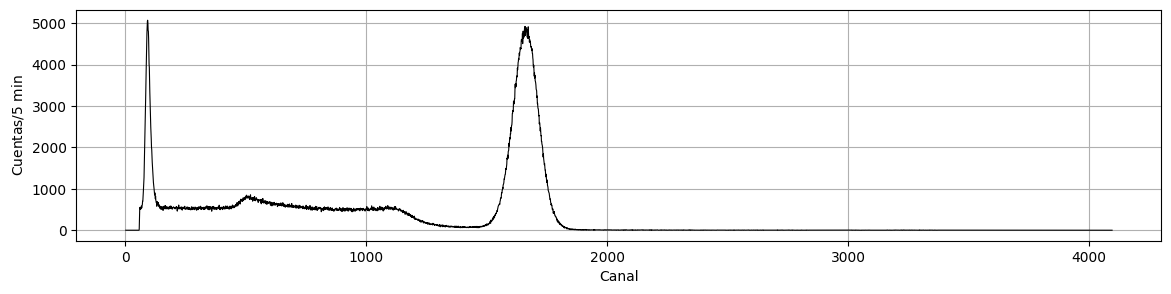


--- Resultados del primer pico ---
 μ1 = 93.3 ± 0.0742 canales
 σ1 = 9.38 ± 0.0816 canales
 FWHM1 = 22.1 ± 0.192 canales
 A1 = 4.32e+03 ± 30.6 cuentas
 a0 = 590 ± 15.6, a1 = -0.141 ± 0.0527
 Intensidad = 1.02e+05 ± 888 cuentas·canal

--- Resultados del segundo pico ---
 μ2 = 1.66e+03 ± 0.0682 canales
 σ2 = 52.2 ± 0.0737 canales
 FWHM2 = 123 ± 0.174 canales
 A2 = 4.75e+03 ± 5.48 cuentas
 a0 = 409 ± 10.5, a1 = -0.211 ± 0.00658
 Intensidad = 6.21e+05 ± 876 cuentas·canal


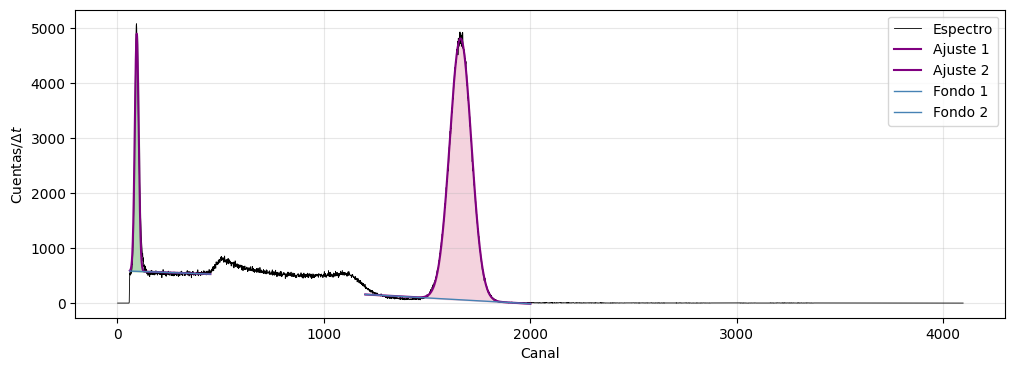

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def gauss_bg(x, mu, sigma, A, a0, a1):                                               # una gaussiana con fondo lineal mx + b
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

#
archivo = "Cs137_5minNaI.csv"                    # archivo con los datos
data = pd.read_csv(archivo)
x = data.iloc[:, 0].values                       # canal
y = data.iloc[:, 1].values                       # cuentas

# para ver el espectro completo
plt.figure(figsize=(14,3))
plt.plot(x, y, lw=0.8, color='black')
plt.xlabel("Canal")
plt.ylabel("Cuentas/$5$ min")                                                         # acomodar el \Delta t de acuerdo al núcleo
plt.grid(True)
plt.show()


# defino la región del primer pico
x_min1, x_max1 = 60, 450                                                              # límites a ojo para empezar
mask1 = (x >= x_min1) & (x <= x_max1)
x_region1 = x[mask1]
y_region1 = y[mask1]

                                                                                      # estimaciones iniciales que voy a ajustar:
mu1_guess = x_region1[np.argmax(y_region1)]                                           # centro inicial en el máximo local
A1_guess = y_region1.max()                                                            # altura inicial
sigma1_guess = 30.0                                                                   # ancho inicial (10% del rango)
a0_guess = np.median(y_region1)                                                       # valor medio como base inicial
a1_guess = 0.0                                                                        # pendiente inicial nula

p0_1 = [mu1_guess, sigma1_guess, A1_guess, a0_guess, a1_guess]

# Ajuste no lineal con todos los parámetros libres
popt1, pcov1 = curve_fit(gauss_bg, x_region1, y_region1, p0=p0_1, maxfev=20000)
mu1, sigma1, A1, a0_1, a1_1 = popt1
perr1 = np.sqrt(np.diag(pcov1))


# defino la región del segundo pico (todo igual pero con estimaciones a ojo para el pico más a la derecha)
x_min2, x_max2 = 1200, 2000
mask2 = (x >= x_min2) & (x <= x_max2)
x_region2 = x[mask2]
y_region2 = y[mask2]

mu2_guess = x_region2[np.argmax(y_region2)]
A2_guess = y_region2.max()
sigma2_guess = 50.0
a0_guess = np.median(y_region2)
a1_guess = 0.0

p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess, a1_guess]

popt2, pcov2 = curve_fit(gauss_bg, x_region2, y_region2, p0=p0_2)
mu2, sigma2, A2, a0_2, a1_2 = popt2
perr2 = np.sqrt(np.diag(pcov2))


c = np.sqrt(2 * np.pi)

def intensidad(A, sigma, pcov):
    varA = pcov[2, 2]
    varsig = pcov[1, 1]
    covA_sig = pcov[2, 1]
    I = A * sigma * c
    varI = (sigma * c) ** 2 * varA + (A * c) ** 2 * varsig + 2 * (sigma * c) * (A * c) * covA_sig
    dI = np.sqrt(varI)
    return I, dI

I1, dI1 = intensidad(A1, sigma1, pcov1)
I2, dI2 = intensidad(A2, sigma2, pcov2)

FWHM1 = 2.355 * sigma1
FWHM2 = 2.355 * sigma2
dFWHM1 = 2.355 * perr1[1]
dFWHM2 = 2.355 * perr2[1]



def fmt(x, dx=None):
    if dx is None or np.isnan(dx):
        return f"{x:.3g}"
    else:
        return f"{x:.3g} ± {dx:.3g}"

print("\n--- Resultados del primer pico ---")
print(f" μ1 = {fmt(mu1, perr1[0])} canales")
print(f" σ1 = {fmt(sigma1, perr1[1])} canales")
print(f" FWHM1 = {fmt(FWHM1, dFWHM1)} canales")
print(f" A1 = {fmt(A1, perr1[2])} cuentas")
print(f" a0 = {fmt(a0_1, perr1[3])}, a1 = {fmt(a1_1, perr1[4])}")
print(f" Intensidad = {fmt(I1, dI1)} cuentas·canal")

print("\n--- Resultados del segundo pico ---")
print(f" μ2 = {fmt(mu2, perr2[0])} canales")
print(f" σ2 = {fmt(sigma2, perr2[1])} canales")
print(f" FWHM2 = {fmt(FWHM2, dFWHM2)} canales")
print(f" A2 = {fmt(A2, perr2[2])} cuentas")
print(f" a0 = {fmt(a0_2, perr2[3])}, a1 = {fmt(a1_2, perr2[4])}")
print(f" Intensidad = {fmt(I2, dI2)} cuentas·canal")


xf1 = np.linspace(x_region1.min(), x_region1.max(), 800)
xf2 = np.linspace(x_region2.min(), x_region2.max(), 800)
fit1 = gauss_bg(xf1, *popt1)
fit2 = gauss_bg(xf2, *popt2)
bg1 = a0_1 + a1_1 * xf1
bg2 = a0_2 + a1_2 * xf2

plt.figure(figsize=(12, 4))
plt.plot(x, y, color='black', lw=0.6, label='Espectro')
plt.plot(xf1, fit1, color='purple', lw=1.5, label="Ajuste 1")
plt.plot(xf2, fit2, color='purple', lw=1.5, label="Ajuste 2")
plt.plot(xf1, bg1, color='steelblue', lw=1, label='Fondo 1')
plt.plot(xf2, bg2,color='steelblue', lw=1, label='Fondo 2')
plt.fill_between(xf1, bg1, fit1, where=(fit1 > bg1), color='green', alpha=0.3)
plt.fill_between(xf2, bg2, fit2, where=(fit2 > bg2), color='palevioletred', alpha=0.3)
plt.xlabel("Canal")
plt.ylabel("Cuentas/$\Delta t$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
